In [1]:
! pip install langchain_community
! pip install -U langgraph
!pip install ipython
!pip install pygraphviz

In [2]:
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoTokenizer,
)
import transformers
import torch
from typing import Dict, TypedDict, Annotated
from langgraph.graph import Graph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from peft import PeftModel
from langgraph.graph.message import add_messages
import json

## Define State

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Utility Functions

In [4]:
def get_formatted_prompt(prompt):
    return f"Task: Convert the JSON configuration below into a valid gst-launch-1.0 pipeline command.\nInput JSON:\n{prompt}\nOutput:\n"

In [5]:
model_name='microsoft/phi-2'
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token
def generate_text_from_model(model, prompt):
    toks = eval_tokenizer(prompt, return_tensors="pt")
    res = model.generate(**toks.to("cuda"), max_new_tokens=500, do_sample=True,num_return_sequences=1,temperature=0.1,num_beams=1,top_p=0.95,).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

## Agent 1: SQL 

In [6]:
def sql_node(state: State) -> State:
    user_input = state["messages"][-1]["content"]
    # Hardcoded JSON response
    mock_sql_result = {
      "source_type": "rtsp",
      "source_location": "rtsp://192.168.1.92:8047/backup_low",
      "caps_filter": "Y444_12BE",
      "frame_rate": "1/1",
      "detect": {
        "model": "/home/user/.local/models/tensorflow/classification/2.0/INT8/model_9689.xml",
        "device": "HDDL",
        "model_proc": "/opt/intel/model_proc/classification/model_1131.json"
      },
      "track": {
        "tracking_type": "zero-term"
      },
      "emit_signals": False,
      "sync": False,
      "drop": False
    }
    
    agent_response = {
        "role": "SQL Agent",
        "content": json.dumps(mock_sql_result)
    }
    
    return {
        "messages": state["messages"] + [agent_response]
    }

## Agent 2: Pipeline Creation 

In [7]:
# Pipeline Creation Node function
def pipeline_creation_node(state: State) -> State:
    compute_dtype = getattr(torch, "float16")
    bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=False,
        )
    base_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)
    
    # Fine Tuned Model
    ft_model = PeftModel.from_pretrained(base_model, "peft_GST_pipeline_training_QLora/final-checkpoint/checkpoint-100",torch_dtype=torch.float16,is_trainable=False)
    
    sql_results = json.loads(state["messages"][-1]["content"])
    
    # Generate response
    formatted_prompt = get_formatted_prompt(sql_results)
    peft_model_res = generate_text_from_model(ft_model,formatted_prompt)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    output, success, result = peft_model_output.partition('\n')
    agent_response = {
        "role": "Pipeline Creation Agent",
        "content": output
    }
    return {
        "messages": state["messages"] + [agent_response]
    }
    

# Graph

In [8]:
# Create the graph
def create_graph():
    # Initialize the graph
    workflow = Graph()
    
    # Add nodes
    workflow.add_node("sql", sql_node)
    workflow.add_node("pipeline_creation", pipeline_creation_node)
    
    # Define edges
    workflow.add_edge("sql", "pipeline_creation")
    
    # Set the entry point
    workflow.set_entry_point("sql")
    
    # Set the exit point
    workflow.add_edge("pipeline_creation", END)
    
    
    return workflow.compile()


In [9]:
# Create the graph
graph = create_graph()

## Visualize Graph

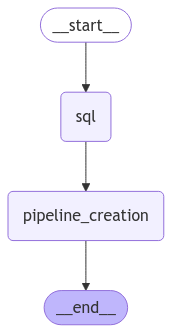

In [10]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Inference

In [11]:
# Define initial state
initial_state = State(
    messages=[
        {
            "role": "user",
            "content": "Setup Occupancy Agent in Bangalore for Nike"
        }
    ]
)

# Run the graph
final_state = graph.invoke(initial_state)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [12]:
# Print conversation flow
final_state

{'messages': [{'role': 'user',
   'content': 'Setup Occupancy Agent in Bangalore for Nike'},
  {'role': 'SQL Agent',
   'content': '{"source_type": "rtsp", "source_location": "rtsp://192.168.1.92:8047/backup_low", "caps_filter": "Y444_12BE", "frame_rate": "1/1", "detect": {"model": "/home/user/.local/models/tensorflow/classification/2.0/INT8/model_9689.xml", "device": "HDDL", "model_proc": "/opt/intel/model_proc/classification/model_1131.json"}, "track": {"tracking_type": "zero-term"}, "emit_signals": false, "sync": false, "drop": false}'},
  {'role': 'Pipeline Creation Agent',
   'content': 'rtspsrc location=rtsp://192.168.1.92:8047/backup_low! rtph264depay! h264parse! avdec_h264! videoconvert! videorate! video/x-raw,framerate=1/1! videoconvert! capsfilter caps=video/x-raw,format=Y444_12BE! queue! gvadetect model=/home/user/.local/models/tensorflow/classification/2.0/INT8/model_9689.xml device=HDDL model-proc=/opt/intel/model_proc/classification/model_1131.json! queue! gvatrack tracki